# Statistical Analysis: A/B testing

# Project Objective
The purpose of this project is to quickly analyze the performance of old page vs new page and conduct an A/B testing to see which one performs better. The metric is conversion rate.

The dataset can be found here: https://www.kaggle.com/datasets/zhangluyuan/ab-testing

# Methods Used
* Inferential Statistics
* Data Visualization
* A/B Testing

# Data Description
The dataset contains 300,000 observations and five columns. The target variable is "converted"

# 1. Quick data cleaning, analysis and visualization

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

In [37]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
# check missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There is no missing values

In [39]:
# check duplicates
df.duplicated().sum()

0

There is no duplicates

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [41]:
# convert timestamp to datetime format and further convert it to YYYY-MM-DD
df['timestamp'] = df['timestamp'].astype('datetime64')
df['daily'] = df['timestamp'].dt.strftime('%Y-%m-%d')

Ideally the control group should be using old page whereas treatment group should be using landing page. Let's do a sanity check to make sure if this is the case

In [42]:
df.query('group=="control"').landing_page.value_counts()

old_page    145274
new_page      1928
Name: landing_page, dtype: int64

In [43]:
df.query('group=="treatment"').landing_page.value_counts()

new_page    145311
old_page      1965
Name: landing_page, dtype: int64

It turns out that is not the case since we still have a handful new page used by control group and old page used by treatment group. I'll go ahead and remove these mismatch observations

In [44]:
df = df.query('group=="control" & landing_page=="old_page"| group=="treatment" & landing_page=="new_page"')

In [45]:
df.group.value_counts()

treatment    145311
control      145274
Name: group, dtype: int64

Since the observations in treatment group and control group are roughly the same (145,311 vs 145,274) so the dataset is balanced. We don't need to use resampling technique to make it balanced

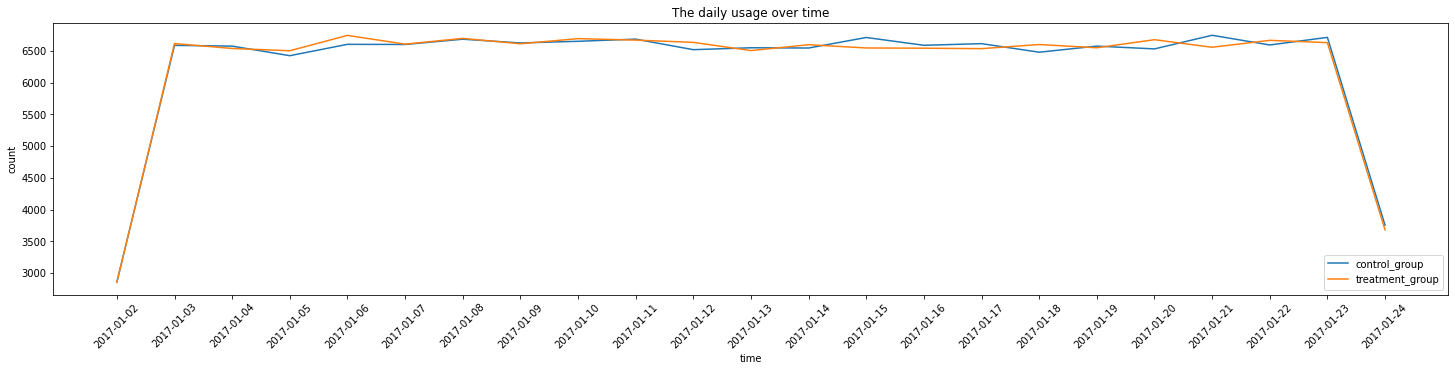

In [47]:
# create a time series plot to show the usage over time
control = df.query('group=="control"').sort_values(by='daily').groupby('daily').user_id.count().reset_index()
treatment = df.query('group=="treatment"').sort_values(by='daily').groupby('daily').user_id.count().reset_index()
plt.figure(figsize=(25,5))
plt.plot(control.daily,control.user_id,label='control_group')
plt.plot(treatment.daily,treatment.user_id,label='treatment_group')
plt.legend()
plt.xlabel('time')
plt.ylabel('count')
plt.title('The daily usage over time')
plt.xticks(rotation=45)
plt.show()

Seems like the usage between control group and treatment group are consistent with a daily usage around 6500 

I'm also curious about the usage by hours between control group and treatment group so I created the below plot to show usage by hours

In [48]:
df['hour']=df.timestamp.dt.hour

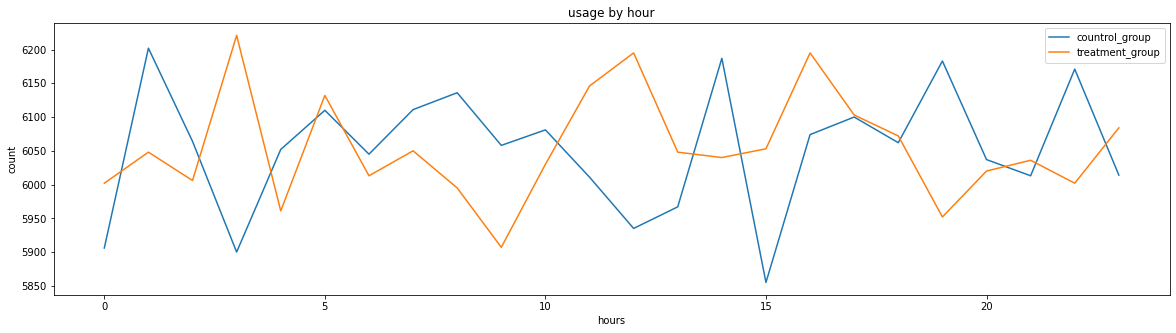

In [52]:
control_hour = df.query('group=="control"').groupby('hour').user_id.count().reset_index().sort_values(by='hour')
treatment_hour = df.query('group=="treatment"').groupby('hour').user_id.count().reset_index().sort_values(by='hour')
plt.figure(figsize=(20,5))
plt.plot(control_hour.hour,control_hour.user_id,label='countrol_group')
plt.plot(treatment_hour.hour,treatment_hour.user_id,label='treatment_group')
plt.title('usage by hour')
plt.legend()
plt.xlabel('hours')
plt.ylabel('count')

plt.show()

Seems like the hourly usage between control group and treatment group is very different. I think there are a few possible reasons
* The company splitted the user into control group and treatment group based on different time slots
* old page and new page affected the user behaviors differently

In [91]:
# to check the conversion rate between control group and treatment group
con = df.groupby('group').converted.value_counts(normalize=True).mul(100).unstack()
print(con)

converted          0          1
group                          
control    87.961370  12.038630
treatment  88.119275  11.880725


From the above table, it appears that the control group (old page) has higher conversion rate. Hypothetically we could end the test here, but Let's conduct an A/B testing to see if we are seeing the same result using a statistical inference method

# 2. A/B Testing
step 1: Define the business question and performance metric
* The business problem is to figure out if we should launch the new page or not
* The performance metric is conversion rate

Step 2: Setup the experiment by selecting appropriate sample sizes and randomized groups. I think we have enough samples since we have a large sample size but let's calculate the sample size needed to detect minimum effect.

Minimum effect - to raise the conversion rate from 12% to 14%

In [94]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,
    alpha=0.05,
    ratio=1)                                                  

sample_size = np.ceil(sample_size)                                             

print(sample_size)

4433.0


We will need 4,433 samples to detect minimum effect

Step 3: Compare group performance and determine if the difference is statistical significant (with hypothesis testing). 

I will use proportions z test since we are dealing with conversion rate problem

H0: the conversion rate between control group and treatment group is the same
H1: the conversion rate between control group and treatment group is different

In [96]:
control = df.query('group=="control"')[['converted']]
treatment = df.query('group=="treatment"')[['converted']]

In [102]:
from statsmodels.stats.proportion import proportions_ztest
counts = [control.converted.sum(), treatment.converted.sum()]
number_of_obs = [control.shape[0], treatment.shape[0]]
z_statistic, p_value = proportions_ztest(counts, number_of_obs)
print(f'z statistic is {z_statistic:.2f} and p-value is {p_value:.2f}')


z statistic is 1.31 and p-value is 0.19


The p-value is 0.19 which means that we cannot reject the null hypothesis at a 5% significance level. The new page does not performs better than the old page and we should not launch the new page